In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf
import glob
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import series_utils
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut

from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Define paths and ref files

In [20]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

In [21]:

schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

## OCC

## Load Data
#### Based on get_all_data from series_utils.py 

In [22]:
occ_pre, subjects_list_occ_pre = series_utils.get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
occ_post, subjects_list_occ_post =  series_utils.get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

In [23]:
all_occ = occ_pre + occ_post
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)

In [24]:
cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']
print(subjects_id_occ)


[ 8  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11  8
  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11]


## Transform dimensions to get shape #subject x #timepoints x #variables

In [7]:
X = np.swapaxes(np.swapaxes(np.dstack(all_occ), 0,2),1,2)
y = np.array(y_occ)
print('X shape:', X.shape)
print('y shape: ', y.shape)

X shape: (46, 600, 15)
y shape:  (46,)


## Define Model

In [9]:
model = tf.keras.Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
scores = []
actual_classes = []
predicted_classes = []
leave = LeaveOneGroupOut()
for train_idx, test_idx in leave.split(X, y, subjects_id_occ):
    scaler_3d = series_utils.Scaler()
    X_train, y_train = X[train_idx], y[train_idx]
    print(X_train.shape)
    X_train_scaled = scaler_3d.fit_transform(X_train)
    model.fit(X_train_scaled, y_train, epochs=10)
    X_test, y_test = X[test_idx], y[test_idx]
    #X_test= np.reshape(X_test, newshape=(X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
    #X_test_scaled = np.reshape(scaler_3d.transform(X_test_r), newshape=X_test.shape)
    X_test_scaled = scaler_3d.transform(X_test)
    scores.append(model.evaluate(X_test_scaled, y_test, verbose=0)[1])
    actual_classes.append(y_test)
    predicted_classes.append(np.hstack(model.predict(X_test_scaled)>0.5)*1)

(44, 600, 15)
Epoch 1/10
2/2 [==============================] - 1s 560ms/step - loss: 0.6844 - accuracy: 0.5682
Epoch 2/10
2/2 [==============================] - 1s 555ms/step - loss: 0.6748 - accuracy: 0.5227
Epoch 3/10
2/2 [==============================] - 1s 554ms/step - loss: 0.6834 - accuracy: 0.5455
Epoch 4/10
2/2 [==============================] - 1s 518ms/step - loss: 0.6728 - accuracy: 0.5455
Epoch 5/10
2/2 [==============================] - 1s 585ms/step - loss: 0.6790 - accuracy: 0.5455
Epoch 6/10
2/2 [==============================] - 1s 497ms/step - loss: 0.6714 - accuracy: 0.5455
Epoch 7/10
2/2 [==============================] - 1s 529ms/step - loss: 0.6785 - accuracy: 0.5455
Epoch 8/10
2/2 [==============================] - 1s 606ms/step - loss: 0.6671 - accuracy: 0.5682
Epoch 9/10
2/2 [==============================] - 1s 545ms/step - loss: 0.6652 - accuracy: 0.5682
Epoch 10/10
2/2 [==============================] - 1s 549ms/step - loss: 0.6672 - accuracy: 0.5909
(44, 

2/2 [==============================] - 1s 532ms/step - loss: 0.2229 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 551ms/step - loss: 0.2353 - accuracy: 0.9545
Epoch 7/10
2/2 [==============================] - 1s 523ms/step - loss: 0.2097 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 1s 536ms/step - loss: 0.2113 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 1s 574ms/step - loss: 0.2449 - accuracy: 0.9773
Epoch 10/10
2/2 [==============================] - 1s 528ms/step - loss: 0.2074 - accuracy: 1.0000
(44, 600, 15)
Epoch 1/10
2/2 [==============================] - 1s 553ms/step - loss: 0.2266 - accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 1s 528ms/step - loss: 0.2088 - accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 540ms/step - loss: 0.1981 - accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 573ms/step - loss: 0.2240 - accuracy: 0.9773
Epoch 5/10
2/2 [

In [13]:
np.mean(scores)

0.8913043478260869

In [17]:
actual_classes_l = np.hstack(actual_classes)
predicted_classes_l = np.hstack(predicted_classes)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

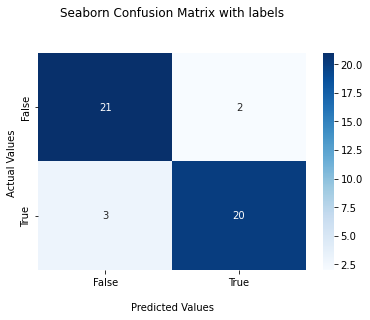

In [18]:
cf_matrix = confusion_matrix(actual_classes_l, predicted_classes_l)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## CONTROL

### Load Data
##### Based on get_all_data from series_utils.py

In [25]:
ctr_pre, subjects_list_ctr_pre = series_utils.get_all_data(['_scan_restpre'], ['ses-ctr'], subjects, dirpath, parcel,schafer)
ctr_post, subjects_list_ctr_post =  series_utils.get_all_data(['_scan_restpost'], ['ses-ctr'], subjects, dirpath, parcel,schafer)

In [26]:
all_ctr = ctr_pre + ctr_post
subjects_ctr = subjects_list_ctr_pre + subjects_list_ctr_post
y_ctr = [0]*len(subjects_list_ctr_pre) + [1]*len(subjects_list_ctr_post)

In [28]:
cat_subjects_ctr = pd.get_dummies(subjects_ctr)

subjects_id_ctr = cat_subjects_ctr.values.argmax(1)

class_names = ['Pre', 'Post']
print(subjects_id_ctr)

[ 8  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11  8
  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11]


## Transform dimensions to get shape #subject x #timepoints x #variables

In [29]:
X_ctr = np.swapaxes(np.swapaxes(np.dstack(all_ctr), 0,2),1,2)
y_ctr = np.array(y_ctr)
print('X shape:', X_ctr.shape)
print('y shape: ', y_ctr.shape)

X shape: (46, 600, 15)
y shape:  (46,)


## Define Model

In [30]:
model = tf.keras.Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
scores = []
actual_classes = []
predicted_classes = []
leave = LeaveOneGroupOut()
for train_idx, test_idx in leave.split(X_ctr, y_ctr, subjects_id_ctr):
    scaler_3d = series_utils.Scaler()
    X_train, y_train = X_ctr[train_idx], y_ctr[train_idx]
    X_train_scaled = scaler_3d.fit_transform(X_train)
    model.fit(X_train_scaled, y_train, epochs=10)
    X_test, y_test = X_ctr[test_idx], y_ctr[test_idx]
    X_test_scaled = scaler_3d.transform(X_test)
    scores.append(model.evaluate(X_test_scaled, y_test, verbose=0)[1])
    actual_classes.append(y_test)
    predicted_classes.append(np.hstack(model.predict(X_test_scaled)>0.5)*1)

Epoch 1/10
2/2 [==============================] - 2s 1s/step - loss: 0.9596 - accuracy: 0.4545
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.9525 - accuracy: 0.4318
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.8937 - accuracy: 0.4318
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.9634 - accuracy: 0.4773
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.9032 - accuracy: 0.4773
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.8509 - accuracy: 0.5682
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.8530 - accuracy: 0.5455
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.8553 - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.8179 - accuracy: 0.5682
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.8103 - accuracy: 0.5227
Epoch 1/10
2/2 [==============================] -

2/2 [==============================] - 2s 1s/step - loss: 0.3341 - accuracy: 0.9318
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.2807 - accuracy: 0.9545
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.3066 - accuracy: 0.9091
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.2870 - accuracy: 0.9545
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.3174 - accuracy: 0.9091
Epoch 1/10
2/2 [==============================] - 2s 953ms/step - loss: 0.2842 - accuracy: 0.9318
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.2913 - accuracy: 0.9318
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.2879 - accuracy: 0.8864
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.2956 - accuracy: 0.9091
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.2918 - accuracy: 0.9091
Epoch 6/10
2/2 [==============================] - 2s 909m

2/2 [==============================] - 2s 1s/step - loss: 0.1699 - accuracy: 0.9773
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.1800 - accuracy: 0.9545
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.1681 - accuracy: 0.9773
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.1766 - accuracy: 0.9773
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.1703 - accuracy: 0.9773
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.2143 - accuracy: 0.9545
Epoch 7/10
2/2 [==============================] - 2s 968ms/step - loss: 0.1683 - accuracy: 0.9773
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.2077 - accuracy: 0.9318
Epoch 9/10
2/2 [==============================] - 2s 973ms/step - loss: 0.1735 - accuracy: 0.9773
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.1572 - accuracy: 0.9773
Epoch 1/10
2/2 [==============================] - 2s 1

In [33]:
np.mean(scores)

0.9130434782608695

In [34]:
actual_classes_l = np.hstack(actual_classes)
predicted_classes_l = np.hstack(predicted_classes)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

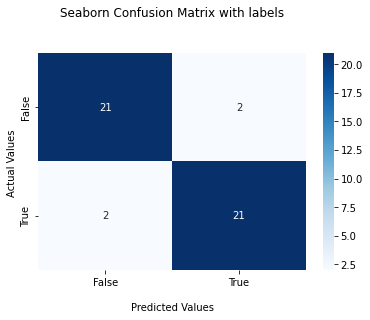

In [35]:
cf_matrix = confusion_matrix(actual_classes_l, predicted_classes_l)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# FRO

### Load Data
##### Based on get_all_data from series_utils.py

In [36]:
fro_pre, subjects_list_fro_pre = series_utils.get_all_data(['_scan_restpre'], ['ses-fro'], subjects, dirpath, parcel,schafer)
fro_post, subjects_list_fro_post =  series_utils.get_all_data(['_scan_restpost'], ['ses-fro'], subjects, dirpath, parcel,schafer)

In [37]:
all_fro = fro_pre + fro_post
subjects_fro = subjects_list_fro_pre + subjects_list_fro_post
y_fro = [0]*len(subjects_list_fro_pre) + [1]*len(subjects_list_fro_post)

In [38]:
cat_subjects_fro = pd.get_dummies(subjects_fro)

subjects_id_fro = cat_subjects_fro.values.argmax(1)

class_names = ['Pre', 'Post']
print(subjects_id_fro)

[ 8  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11  8
  6 20 17  7 22 14  0 21  5  9  2 16 19  1  4 13 18  3 10 12 15 11]


## Transform dimensions to get shape #subject x #timepoints x #variables


In [39]:
X_fro = np.swapaxes(np.swapaxes(np.dstack(all_fro), 0,2),1,2)
y_fro = np.array(y_fro)
print('X shape:', X_fro.shape)
print('y shape: ', y_fro.shape)

X shape: (46, 600, 15)
y shape:  (46,)


## Define Model

In [40]:
model = tf.keras.Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
scores = []
actual_classes = []
predicted_classes = []
leave = LeaveOneGroupOut()
for train_idx, test_idx in leave.split(X_fro, y_fro, subjects_id_ctr):
    scaler_3d = series_utils.Scaler()
    X_train, y_train = X_fro[train_idx], y_fro[train_idx]
    X_train_scaled = scaler_3d.fit_transform(X_train)
    model.fit(X_train_scaled, y_train, epochs=10)
    X_test, y_test = X_fro[test_idx], y_fro[test_idx]
    X_test_scaled = scaler_3d.transform(X_test)
    scores.append(model.evaluate(X_test_scaled, y_test, verbose=0)[1])
    actual_classes.append(y_test)
    predicted_classes.append(np.hstack(model.predict(X_test_scaled)>0.5)*1)

Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.7382 - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.7461 - accuracy: 0.5227
Epoch 3/10
2/2 [==============================] - 2s 964ms/step - loss: 0.7259 - accuracy: 0.5455
Epoch 4/10
2/2 [==============================] - 2s 918ms/step - loss: 0.7323 - accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 2s 946ms/step - loss: 0.7271 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 2s 924ms/step - loss: 0.7354 - accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 2s 914ms/step - loss: 0.7067 - accuracy: 0.4318
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.6965 - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 2s 925ms/step - loss: 0.6954 - accuracy: 0.5455
Epoch 10/10
2/2 [==============================] - 2s 952ms/step - loss: 0.6957 - accuracy: 0.5227
Epoch 1/10
2/2 [============

2/2 [==============================] - 1s 532ms/step - loss: 0.4897 - accuracy: 0.8636
Epoch 7/10
2/2 [==============================] - 1s 424ms/step - loss: 0.4978 - accuracy: 0.8409
Epoch 8/10
2/2 [==============================] - 1s 413ms/step - loss: 0.4871 - accuracy: 0.8636
Epoch 9/10
2/2 [==============================] - 1s 400ms/step - loss: 0.4792 - accuracy: 0.9091
Epoch 10/10
2/2 [==============================] - 1s 414ms/step - loss: 0.4690 - accuracy: 0.8409
Epoch 1/10
2/2 [==============================] - 1s 754ms/step - loss: 0.4818 - accuracy: 0.8409
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.4568 - accuracy: 0.7955
Epoch 3/10
2/2 [==============================] - 2s 959ms/step - loss: 0.4818 - accuracy: 0.8864
Epoch 4/10
2/2 [==============================] - 2s 916ms/step - loss: 0.4743 - accuracy: 0.8409
Epoch 5/10
2/2 [==============================] - 2s 888ms/step - loss: 0.4651 - accuracy: 0.8864
Epoch 6/10
2/2 [=================

2/2 [==============================] - 2s 710ms/step - loss: 0.2275 - accuracy: 0.9773
Epoch 10/10
2/2 [==============================] - 2s 915ms/step - loss: 0.2046 - accuracy: 0.9773
Epoch 1/10
2/2 [==============================] - 2s 913ms/step - loss: 0.2161 - accuracy: 0.9773
Epoch 2/10
2/2 [==============================] - 2s 906ms/step - loss: 0.2067 - accuracy: 0.9773
Epoch 3/10
2/2 [==============================] - 2s 685ms/step - loss: 0.1976 - accuracy: 0.9773
Epoch 4/10
2/2 [==============================] - 1s 608ms/step - loss: 0.2040 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 702ms/step - loss: 0.2014 - accuracy: 0.9773
Epoch 6/10
2/2 [==============================] - 1s 677ms/step - loss: 0.2021 - accuracy: 0.9545
Epoch 7/10
2/2 [==============================] - 1s 617ms/step - loss: 0.2020 - accuracy: 0.9773
Epoch 8/10
2/2 [==============================] - 1s 688ms/step - loss: 0.1960 - accuracy: 0.9773
Epoch 9/10
2/2 [==============

In [42]:
np.mean(scores)

0.8043478260869565

In [43]:
actual_classes_l = np.hstack(actual_classes)
predicted_classes_l = np.hstack(predicted_classes)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

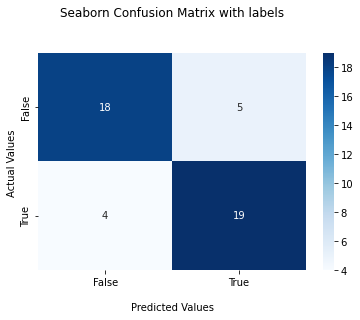

In [44]:
cf_matrix = confusion_matrix(actual_classes_l, predicted_classes_l)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])